<img src="../../img/timeseries_construction.png" alt="time series construction" style="width: 100%; border-radius: 20px;"/>

## Objective
This notebook aims to generate time series data from the german and swiss bird sightings of 2018-2022. The time series form the dataset for the subsequent implementation of a change point detection algorithm. This algorithm will be utilized to distinguish between anomalies, collective anomalies, and systematic concept drifts. The ultimate goal is to gain insights into the patterns and changes in bird sightings over time and to differentiate between various types of deviations in the data.

## Scope
In this notebook, time series will be constructed by aligning the number of species sightings from 2018-2022 with their respective sighting dates for each species and region. For demonstration purposes, time series of the pygmy owl and the icterine warbler are visualized.

In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import pandas as pd
import plotly.express as px

from utils.plotting import *

import warnings
warnings.filterwarnings("ignore")

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 0️⃣ Specify your paths </p>

In order to run the notebook, the following file is required:
- Master dataset reduced to 27 species and enriched with EEA grids and land cover information: *[master_train.csv](https://drive.google.com/drive/folders/18XoTsDtWnN4QdIBNGGbq-jaa6U3nVb2e)*

As output, we provide a dataframe containing the time series of the number of sightings from 2018-2022 for all species and grids. If you wish to store it, please specify a target path.

In [2]:
path_sightings = '../../../01_Data/datasets/evaluation_data/master_train.csv'

target_path = '../../../01_Data/datasets/'

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 1️⃣ Load data </p>


In [3]:
sightings = pd.read_csv(path_sightings, index_col=0, low_memory=False)
sightings['date'] = pd.to_datetime(sightings.date)
sightings

,id_sighting,id_species,name_species,date,coord_lat,coord_lon,altitude,total_count,atlas_code,country,eea_grid_id,land_use_coord,land_use_coord_numeric
0,29666972,8,Haubentaucher,2018-01-01,53.157760,8.676993,-1,0,NaN,de,50kmE4200N3300,water,14
1,29654244,397,Schwarzkehlchen,2018-01-01,53.127639,8.957263,1,2,NaN,de,50kmE4250N3300,agriculture,3
2,29654521,463,Wiesenpieper,2018-01-01,50.850941,12.146953,269,2,NaN,de,50kmE4450N3050,urban,1
3,29666414,8,Haubentaucher,2018-01-01,51.076006,11.038316,157,8,NaN,de,50kmE4350N3100,water,14
4,29656211,8,Haubentaucher,2018-01-01,51.389380,7.067282,52,10,NaN,de,50kmE4100N3100,urban,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2660038,27523548,469,Bergpieper,2022-08-01,46.563896,8.551648,2085,4,0,ch,50kmE4200N2600,grassland,5
2660039,27523686,338,Mittelspecht,2022-10-08,47.383318,7.666533,798,1,0,ch,50kmE4100N2650,agriculture,3
2660040,15002272,123,Bergente,2018-02-17,47.512154,9.436332,390,1,0,ch,50kmE4250N2700,water,14
2660041,15002282,8,Haubentaucher,2018-02-17,47.512154,9.436332,390,1,0,ch,50kmE4250N2700,water,14


# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 2️⃣ Time series construction </p>

The aim of this chapter is to generate a continuous time series for each of the 27 bird species and 50x50km EEA-Grid, ranging from January 1, 2018, to December 31, 2022. To achieve this, an empty pandas dataframe is first created, which contains every combination of the features `name_species`, `eea_grid_id`, and all dates from 2018-2022.

In [4]:
grid_list = sightings.eea_grid_id.unique()
date_list = pd.date_range(start='2018-01-01', end='2022-12-31')
species_list = sightings.name_species.unique()
all_combinations = pd.MultiIndex.from_product([species_list, grid_list, date_list], names=['name_species', 'eea_grid_id', 'date'])
all_combinations = pd.DataFrame(index=all_combinations).reset_index()
all_combinations

,name_species,eea_grid_id,date
0,Haubentaucher,50kmE4200N3300,2018-01-01
1,Haubentaucher,50kmE4200N3300,2018-01-02
2,Haubentaucher,50kmE4200N3300,2018-01-03
3,Haubentaucher,50kmE4200N3300,2018-01-04
4,Haubentaucher,50kmE4200N3300,2018-01-05
...,...,...,...
11339455,Gänsegeier,50kmE4150N2500,2022-12-27
11339456,Gänsegeier,50kmE4150N2500,2022-12-28
11339457,Gänsegeier,50kmE4150N2500,2022-12-29
11339458,Gänsegeier,50kmE4150N2500,2022-12-30


Subsequently, the sightings for each of these combinations can be counted through a merge. Then, `n_sightings` contains the number of sightings for the respective species in the specified grid and on the specified date.

In [5]:
sightings_count = sightings.groupby(['name_species', 'eea_grid_id', 'date']).size().reset_index(name='n_sightings')
all_combinations = all_combinations.merge(sightings_count, on=['name_species', 'eea_grid_id', 'date'], how='left')
all_combinations['n_sightings'] = all_combinations['n_sightings'].fillna(0)
all_combinations

,name_species,eea_grid_id,date,n_sightings
0,Haubentaucher,50kmE4200N3300,2018-01-01,12.0
1,Haubentaucher,50kmE4200N3300,2018-01-02,11.0
2,Haubentaucher,50kmE4200N3300,2018-01-03,0.0
3,Haubentaucher,50kmE4200N3300,2018-01-04,7.0
4,Haubentaucher,50kmE4200N3300,2018-01-05,7.0
...,...,...,...,...
11339455,Gänsegeier,50kmE4150N2500,2022-12-27,0.0
11339456,Gänsegeier,50kmE4150N2500,2022-12-28,0.0
11339457,Gänsegeier,50kmE4150N2500,2022-12-29,0.0
11339458,Gänsegeier,50kmE4150N2500,2022-12-30,0.0


For later use, the dataset can optionally be saved as a csv file. Specify the target path in Chapter 0️⃣ above.

In [6]:
# all_combinations.to_csv(target_path + 'time_series_27_species.csv', index=False)

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 3️⃣ Visualization </p>

For demonstration purposes, the time series spanning from January 1, 2018, to December 31, 2022 are plotted for the pygmy owl in grid 50kmE4100N2700 (a grid around Basel, CH), as well as for the icterine warbler in 50kmE4100N3250 (a grid around Hannover, DE).

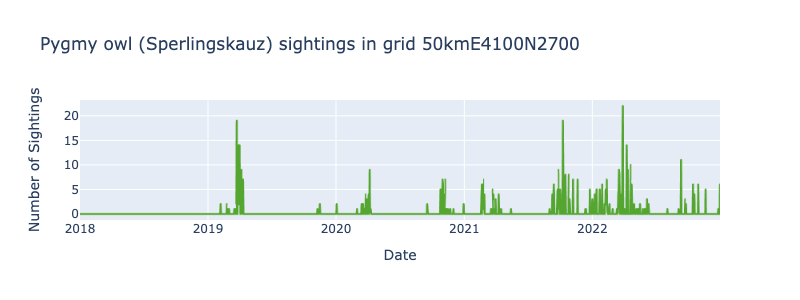

In [7]:
pygmy_owl = all_combinations[(all_combinations['eea_grid_id'] == '50kmE4100N2700') & (all_combinations['name_species'] == 'Sperlingskauz')]
plot_time_series(data=pygmy_owl, title='Pygmy owl (Sperlingskauz) sightings in grid 50kmE4100N2700')

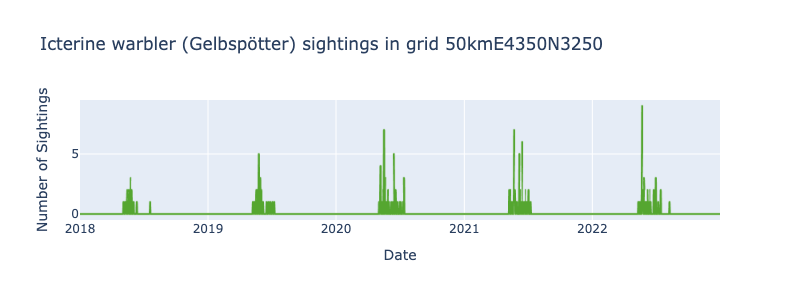

In [8]:
warbler = all_combinations[(all_combinations['eea_grid_id'] == '50kmE4100N3250') & (all_combinations['name_species'] == 'Gelbspötter')]
plot_time_series(data=warbler, title='Icterine warbler (Gelbspötter) sightings in grid 50kmE4350N3250')

# 
<p style="background-color:#4A3228;color:white;font-size:240%;border-radius:10px 10px 10px 10px;"> &nbsp; 4️⃣ Discussion and Outlook </p>

These time series will be leveraged in the following notebook `05_change_point_detection.ipynb` to detect shifts in the birds distribution and sighting days.

The time series currently exhibit spikes, fluctuations, and irregularities and rely on the number of sightings per species, day, and grid. Therefore, in the subsequent notebooks `05_change_point_detection.ipynb` and `06_time_series_decade_smoothing.ipynb`, methods will be employed to preprocess the time series data to make it more amendable for drift detection.